In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [9]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [10]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.4))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.4))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.4))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [11]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


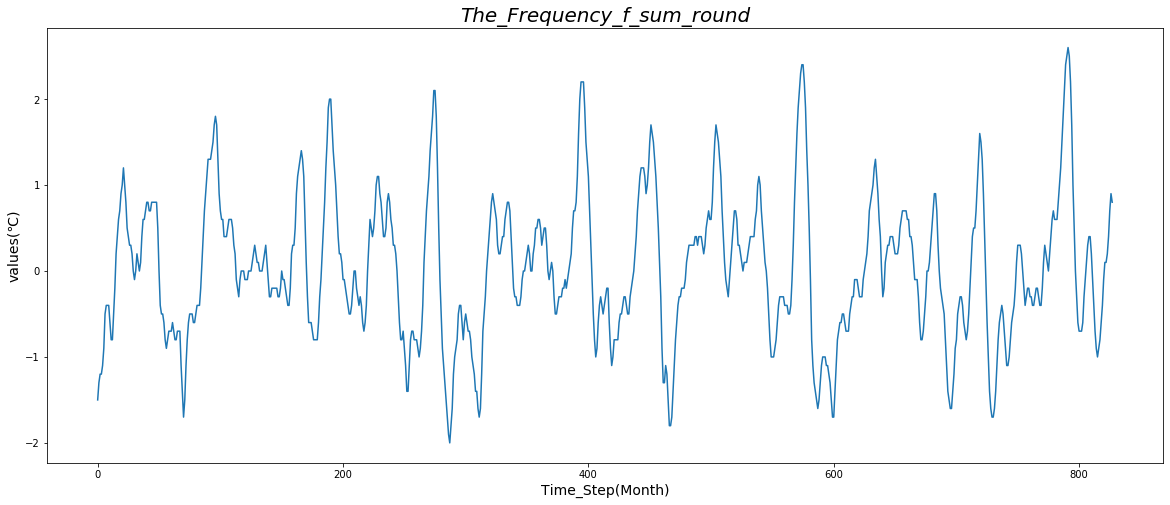

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 21s - loss: 0.6513
Epoch 2/200
 - 6s - loss: 0.5675
Epoch 3/200
 - 7s - loss: 0.4862
Epoch 4/200
 - 8s - loss: 0.4336
Epoch 5/200
 - 7s - loss: 0.4065
Epoch 6/200
 - 6s - loss: 0.3993
Epoch 7/200
 - 6s - loss: 0.3655
Epoch 8/200
 - 4s - loss: 0.3597
Epoch 9/200
 - 5s - loss: 0.3393
Epoch 10/200
 - 4s - loss: 0.3452
Epoch 11/200
 - 4s - loss: 0.3365
Epoch 12/200
 - 4s - loss: 0.3237
Epoch 13/200
 - 4s - loss: 0.3123
Epoch 14/200
 - 4s - loss: 0.3134
Epoch 15/200
 - 4s - loss: 0.3081
Epoch 16/200
 - 5s - loss: 0.3010
Epoch 17/200
 - 5s - loss: 0.3009
Epoch 18/200
 - 8s - loss: 0.2827
Epoch 19/200
 - 5s - loss: 0.2749
Epoch 20/200
 - 6s - loss: 0.2586
Epoch 21/200
 - 5s - loss: 0.2609
Epoch 22/200
 - 4s - loss: 0.2602
Epoch 23/200
 - 5s - loss

(66, 12)


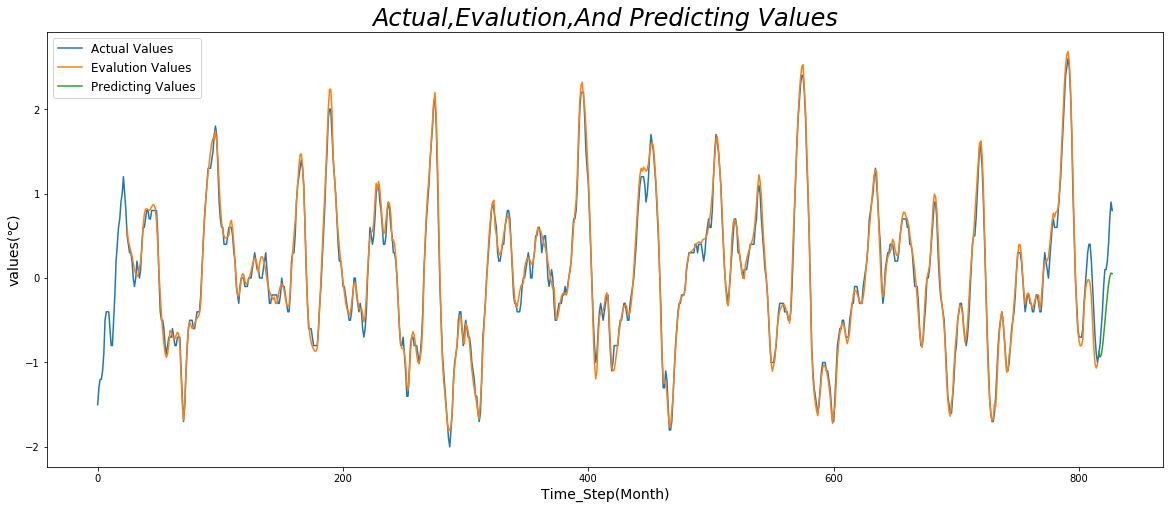

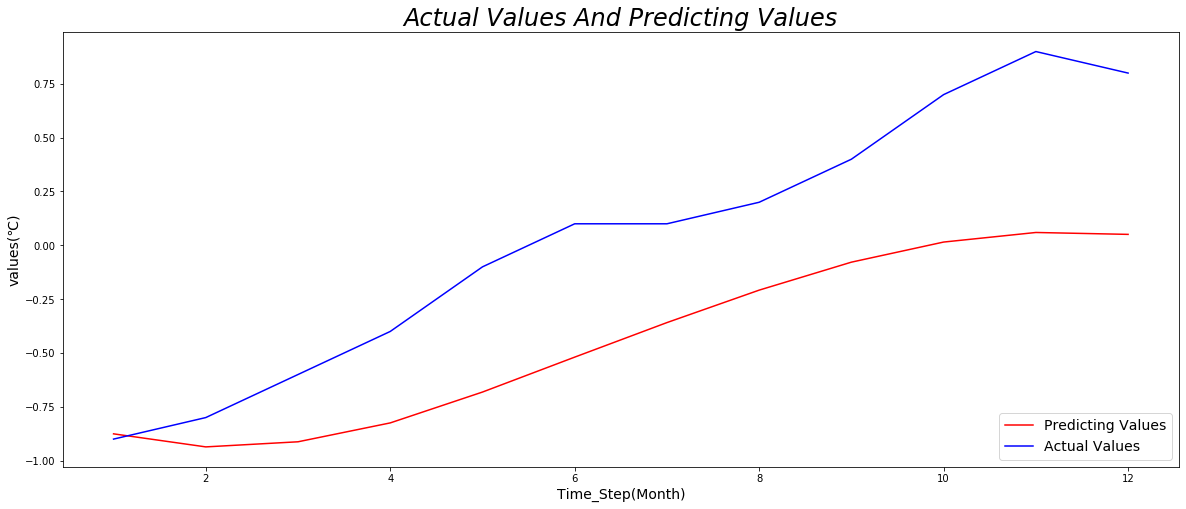

In [13]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

df['f_sum'] = df["f0"]+df["f1"]+df["f2"]+df["f3"]+df["f4"]+df["f5"]+df["f6"]+df["f7"]+df["f8"]

df['f_sum_round']=np.around(df['f_sum'], decimals=1)


for i in range(1):
    #index_name="f"+str(i)
    index_name="f_sum_round"
    dataset = df['f_sum_round'][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    

    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [14]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[-0.8755856 ]
 [-0.93619615]
 [-0.91247964]
 [-0.82478344]
 [-0.681487  ]
 [-0.51926357]
 [-0.3588599 ]
 [-0.20808902]
 [-0.07820632]
 [ 0.01518058]
 [ 0.05964225]
 [ 0.05084375]]
[array([-0.9, -0.8, -0.6, -0.4, -0.1,  0.1,  0.1,  0.2,  0.4,  0.7,  0.9,
        0.8])]
[array([[-0.8755856 ],
       [-0.93619615],
       [-0.91247964],
       [-0.82478344],
       [-0.681487  ],
       [-0.51926357],
       [-0.3588599 ],
       [-0.20808902],
       [-0.07820632],
       [ 0.01518058],
       [ 0.05964225],
       [ 0.05084375]], dtype=float32)]


In [15]:
true_values=np.zeros((12,1))
for i in range(len(prediction_in_one)):
    print ("observe value:{0}".format(real_in_one[i]))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)

observe value:[-0.9 -0.8 -0.6 -0.4 -0.1  0.1  0.1  0.2  0.4  0.7  0.9  0.8]
[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]


In [21]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.8755856  -0.93619615 -0.91247964 -0.82478344 -0.681487   -0.51926357
 -0.3588599  -0.20808902 -0.07820632  0.01518058  0.05964225  0.05084375]
[-0.87558562 -0.93619615 -0.91247964 -0.82478344 -0.68148702 -0.51926357
 -0.3588599  -0.20808902 -0.07820632  0.01518058  0.05964225  0.05084375]


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
%matplotlib inline
#predicted_values=np.array([-0.9138631,-0.64577143,-0.46778013,-0.41380659,-0.29520753,-0.01224175,0.26282753,0.38837113,0.51434888,0.69200458,0.78456772,0.7583482])
round_true_values=np.array([-0.9,-0.8,-0.6,-0.4,-0.1,0.1,0.1,0.2,0.4,0.7,0.9,0.8])


[-0.9 -0.8 -0.6 -0.4 -0.1  0.1  0.1  0.2  0.4  0.7  0.9  0.8]
[-0.87558562 -0.93619615 -0.91247964 -0.82478344 -0.68148702 -0.51926357
 -0.3588599  -0.20808902 -0.07820632  0.01518058  0.05964225  0.05084375]


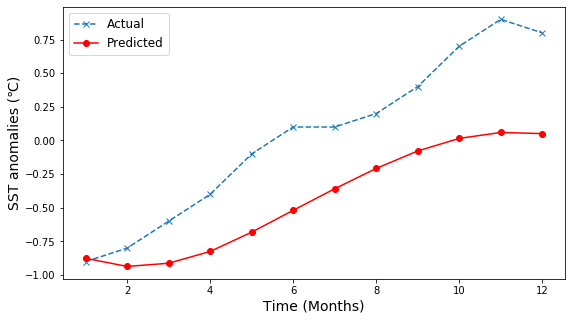

In [23]:
import os
print (round_true_values)
print (predicted_values)


plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 
plt.show() 
